<a href="https://colab.research.google.com/github/chrishare/colab_deeplearning/blob/master/fuel_efficiency_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
""" Code is largely taken from:

https://www.tensorflow.org/tutorials/keras/basic_regression

Okay, this problem is about estimating the fuel efficiency of various
petrol cars based on the engine and vehicle details. The dataset comes from
the UCI Machine Learning Repository here: 
https://archive.ics.uci.edu/ml/datasets/auto+mpg

We are going to use Tensorflow to perform regression on the testset after
performing data cleansing and building a model and training on our training
data, to estimate the MPG (miles per gallon) 
"""

' Code is largely taken from:\n\nhttps://www.tensorflow.org/tutorials/keras/basic_regression\n\nOkay, this problem is about estimating the fuel efficiency of various\npetrol cars based on the engine and vehicle details. The dataset comes from\nthe UCI Machine Learning Repository here: \nhttps://archive.ics.uci.edu/ml/datasets/auto+mpg\n\nWe are going to use Tensorflow to perform regression on the testset after\nperforming data cleansing and building a model and training on our training\ndata, to estimate the MPG (miles per gallon) \n'

In [32]:
# Use seaborn for pairplot
!pip install seaborn

In [33]:
# Okay, this line is importing some code that allows us to write Python 2 and 3
# compatible code by doing nothing for Python 3 (these are already there in 
# python 3) and importing these new Python-3 feautures in Python 2
from __future__ import absolute_import, division, print_function

# This module helps us operate with directory paths
import pathlib

# Pandas is for data structures and analysis, and seaborn is a visualisation
# layer on top of matplotlib
import pandas as pd
import seaborn as sns

# Tensorflow and Keras are our ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# print the tensorflow version - should be 1.12+
print(tf.__version__)

1.12.0


In [34]:
# Retrieve the file using our helper (this does a HTTP GET so you need net)
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

# Read the CSV into a datastructure using pandas to get a pandas dataframe,
# which is a big 2d array that we can mutate
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

# Make a copy, since we'll be cleaning the data and want the original handy
dataset = raw_dataset.copy()
# View the data
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [35]:
"""
Okay, so our data looks like this (from the UCI site listed earlier):
1. mpg: continuous, scalar float - miles per gallon. This is our label.
2. cylinders: multi-valued discrete, scalar in - number of engine cylinders.
3. displacement: continuous, scalar float - total capacity of all the cylinders.
4. horsepower: continuous, scalar float - engine's power output (1 per 746 watts per second).
5. weight: continuous, scalar float - total weight of the vehicle in pounds. 
6. acceleration: continuous, scalar float - miles per second per second.
7. model year: multi-valued discrete, the year the car was manufactured.
8. origin: multi-valued discrete, the region it was designed and built in. 1 for USA, 2 for Europe, 3 for Japan.
9. car name: string (unique for each instance) - we dropped this.
"""

# Check if we have unknown (n/a) values - isna() will list them, sum will count them
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
# Since the Horsepower column had na values, let's drop rows associated with the
# na values in that column
dataset = dataset.dropna()

In [37]:
""" The Origin column is 1 for USA manufactured cars, 2 for Europe, 3 for Japan.
If we leave it as numeric, it will mislead our model, since the deep learning
techniques we will use do not understand that this information is categorical.
So, let's drop the origin column, and add three more columns for USA, Europe and
Japan with each having a value of 1.0 when it was built there. This is called
one-hot encoding.
"""
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [0]:
""" Now we need to split the dataset. For this simple task, we want:
Training set - What we will use to build our model. We use 80% of the total.
Test set - What we will use to evaluate our final model's usefulness.

We may have further sets like a validation set, which is used for evaluation during
training.

"""

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

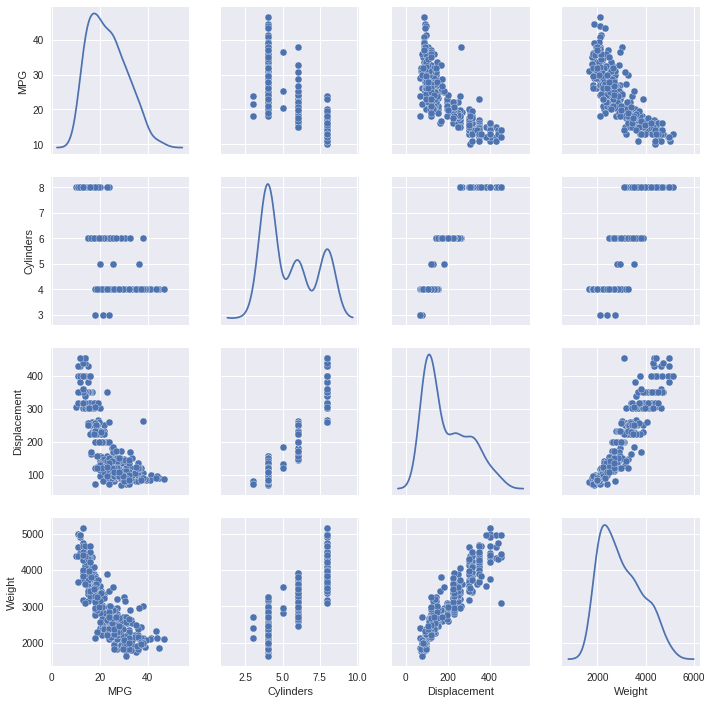

In [39]:
""" Use seaborn to visualize relationships between pairs of variables. KDE 
stands for kernel density estimation - see 
https://en.wikipedia.org/wiki/Kernel_density_estimation. So, we should end up 
with 4 x 4 = 16 diagrams, with the diagonals being line charts estimating the
density of that column. The other charts will be plotting one variable versus
the other, so we can see if there are any patterns. Exploring data like this
can tip us off to useful features, trends and noise, etc.
"""
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [40]:
# This code is going to give us a numeric breakdown of the distribution, this 
# time in a table. We don't care about MPG, just the input features. It will
# give us counts, means, standard deviations, and ranges.
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [41]:
train_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,28.0,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,22.3,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,12.0,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,38.0,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,33.8,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,1.0
257,19.4,6,232.0,90.0,3210.0,17.2,78,1.0,0.0,0.0
310,38.1,4,89.0,60.0,1968.0,18.8,80,0.0,0.0,1.0
328,30.0,4,146.0,67.0,3250.0,21.8,80,0.0,1.0,0.0
125,20.0,6,198.0,95.0,3102.0,16.5,74,1.0,0.0,0.0
108,20.0,4,97.0,88.0,2279.0,19.0,73,0.0,0.0,1.0


In [0]:
# Now we need to get the labels as seperate pd frames.
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

# We also want to normalise the data, which will help the model converge on 
# a good solution faster. Here we will subtract the mean from each instance
# (centre) and scale to get a measure of the variance. We use the training
# mean and deviation even for the test set, since we want the sets to use
# the same distribution. Also, instances for predictions etc need to 
# be normalised too in the future!
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [43]:
""" Time to build our model. Our model will be
Input layer - 9 features
Hidden 1 = 64 neurons, fully connected, relu activation
Hidden 2 = 64 neurons, fully connected, rele activation
Output = 1 neuron, fully connected. Will output the expected efficiency.

Keras will add a bias input to each neuron. Given this, we have (9 + 1) * 64
parameters in the first hidden layer, etc. All of these weights are trainable.
We might want to freeze (not train) weights when we have layers we are reusing
from a pretrained model. Keras will use a default weight initializer of
random_uniform around -0.05 and 0.05 for regular weights and 0 for a bias.

The relu is defined as max(0, x). See 
https://en.wikipedia.org/wiki/Rectifier_(neural_networks). This is thought to be
biologically plausible, that animal synapses could use something like relu. The
wiki link goes into the strengths and weaknesses of relu, but as of 2018, it is
a strong, common choice.

We use RMSProp with a learning rate of 0.001. RMSprop is the root mean squared
propogation method of optimizing a function (our DNN, here). More information
is here https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp.

We use the mean squared error between the labelled MPG and the predicted MPG as
our loss function, which is what we're minimizing.

For a metric as to how we are doing, we use the mean squared error and mean
absolute error. These will be printed as we train. 
"""
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Let's get an instance of our model, and a summary
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Quick test. Take 10 instances and make predictions (model is not trained yet).
# This will help us proove the model is outputting the right shape and values.
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.1597458 ],
       [ 0.08915726],
       [-1.0635914 ],
       [ 0.16190548],
       [ 0.29068264],
       [ 0.0417052 ],
       [ 0.36618057],
       [-0.22304937],
       [-0.05787867],
       [ 0.12058385]], dtype=float32)

In [45]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# We will train on 1000 epochs, meaning 1000 full runs through the training data
EPOCHS = 1000

# Actually perform the training. Here we feed it the training data that we
# normalised, the labels, in minibatches of 32 by default. We also say to use
# 20% of the training set as the validation set. We calculate the loss on this.
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [46]:
# The history object has stats about the training process, using the metric we 
# specified. Let's check out the last few epichs.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.394378,0.983427,2.394378,10.207867,2.458426,10.207867,995
996,2.284019,0.987580,2.284019,9.445489,2.278324,9.445489,996
997,2.422794,1.032238,2.422794,9.009999,2.253269,9.009999,997
998,2.389674,0.966296,2.389674,9.860119,2.392871,9.860119,998
999,2.346663,0.981931,2.346663,9.595284,2.304135,9.595284,999


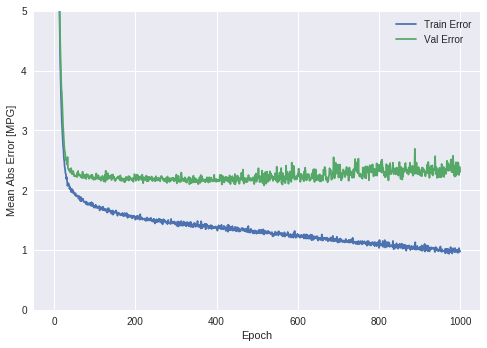

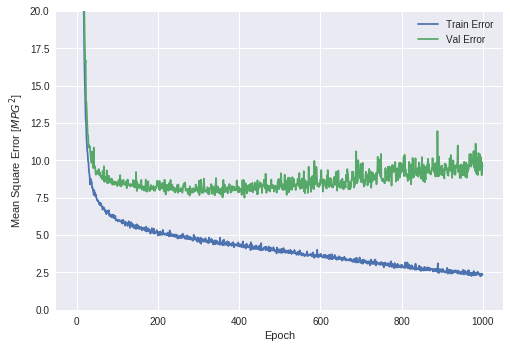

In [47]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,5])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,20])

plot_history(history)


.........................................................................................

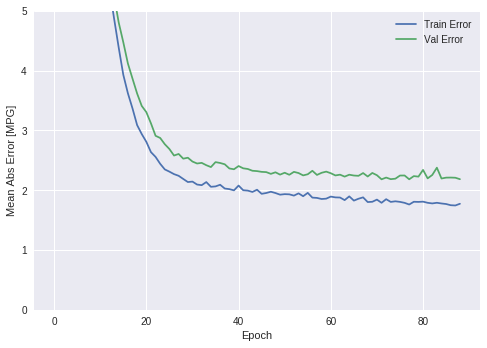

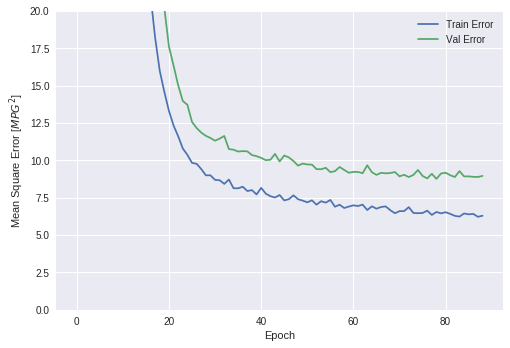

In [49]:
# The model trained pretty well, but didn't improve much after a hundred or two
# epochs. So, let's stop early when we see the validation loss increases after
# 10 epochs. We have to clear the model to start again.
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [50]:
# So, our model is generally making an error of about 2MPG. That's pretty good.
# Let's see if this holds up on the test set. Hint: It does. 
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.96 MPG


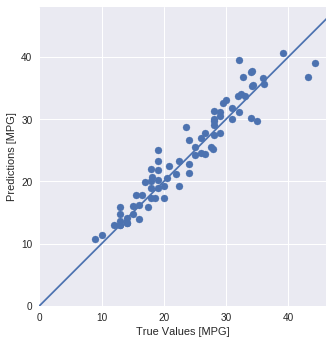

In [51]:
# Let's see if our predictions are pretty close across the different MPG 
# values. We will get the prediction values on the test set, and then
# show a scatter plot of the true vs predicted MPG.
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

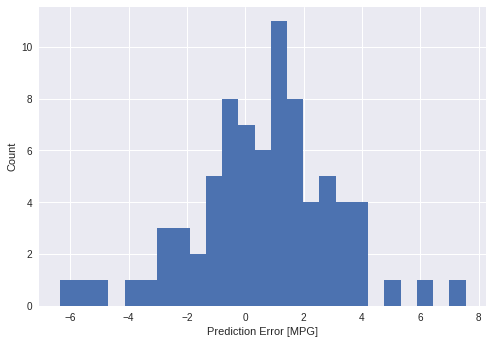

In [53]:
# Finally, let's see how many instances get what approximate error.
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")